In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Policy Iteration Mario
<p style="color:blue;">
By Pramod Sharma : pramod.sharma@prasami.com
<p>
Dated: 02-Feb- 2020

## Acknowledgements
### Standford University<br>
Inspired from: https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl

In [2]:
# Import statements

import numpy as np
import os
import matplotlib.pyplot as plt

from utils.gridWorldGame import standard_grid, negative_grid, print_values, print_policy

<img src = './images/mario_game.png'>


In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24
STEPS = 200

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)


SMALL_ENOUGH = 1e-3
GAMMA = 0.95
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [4]:
# Helper function to plot the grid

def show_grid(val):
    plot_grid = np.zeros(12, dtype = np.float).reshape(3,4)
    for key in val:
        plot_grid[key[0],key[1]] = val[key]
    plot_grid[0,3] = 1
    plot_grid[1,3] = -1
    plot_grid[1,1] = 0
    print ( plot_grid)
    plt.matshow(plot_grid, cmap = 'RdBu');

In [5]:
# Lets create a Grid for our Mario
grid = negative_grid()
print("Rewards:")
print_values(grid.rewards, grid)

Rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


## Actions

In [6]:
# Note: Grid Action keys are defined along with the grid
# What are the keys?
print ("Action Keys:", grid.actions.keys())

Action Keys: dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 2), (2, 3)])


In [7]:
# What actions are possible at each of the location???

grid.actions

{(0, 0): ('D', 'R'),
 (0, 1): ('L', 'R'),
 (0, 2): ('L', 'D', 'R'),
 (1, 0): ('U', 'D'),
 (1, 2): ('U', 'D', 'R'),
 (2, 0): ('U', 'R'),
 (2, 1): ('L', 'R'),
 (2, 2): ('L', 'R', 'U'),
 (2, 3): ('L', 'U')}

<img src = './images/mario_game.png' style="width:300px;">

**Note**: No action defined for terminal state

## Define Policies for these actions

In [8]:
# Let's Define a Dict for policy
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
    
# initial policy
print("Initial policy:")
print_policy(policy, grid)

Initial policy:
---------------------------
  R  |  D  |  D  |     |
---------------------------
  R  |     |  D  |     |
---------------------------
  U  |  D  |  L  |  R  |


## States

In [9]:
states = grid.all_states()
print ('States:', states)

States: {(0, 0), (1, 3), (2, 1), (2, 3), (1, 0), (0, 3), (0, 1), (1, 2), (2, 0), (2, 2), (0, 2)}


In [10]:
print ('Actions:', grid.actions)

Actions: {(0, 0): ('D', 'R'), (0, 1): ('L', 'R'), (0, 2): ('L', 'D', 'R'), (1, 0): ('U', 'D'), (1, 2): ('U', 'D', 'R'), (2, 0): ('U', 'R'), (2, 1): ('L', 'R'), (2, 2): ('L', 'R', 'U'), (2, 3): ('L', 'U')}


In [11]:
# Initialize V(s) - value function
# Again a dict with keys as states
# Random initialization of all Values where action is needed
# zero for terminal states
V = {}

for s in states:
    
    if s in grid.actions:
        V[s] = np.random.random()
    else:
        V[s] = 0

# Initial value for all states in grid
# print(V)
print_values(V, grid)

---------------------------
 0.36| 0.37| 0.24| 0.00|
---------------------------
 0.73| 0.00| 0.17| 0.00|
---------------------------
 0.01| 0.99| 0.34| 0.59|


[[ 0.36332355  0.36957489  0.23863538  1.        ]
 [ 0.72825602  0.          0.16870283 -1.        ]
 [ 0.00862727  0.98954306  0.34246636  0.58764994]]


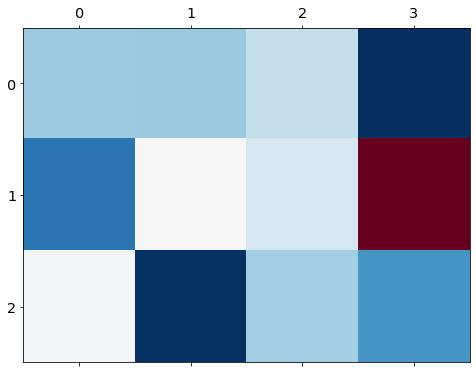

In [12]:
show_grid(V)

In [13]:
print(policy)

{(0, 0): 'R', (0, 1): 'D', (0, 2): 'D', (1, 0): 'R', (1, 2): 'D', (2, 0): 'U', (2, 1): 'D', (2, 2): 'L', (2, 3): 'R'}


In [14]:
print(V)

{(0, 0): 0.3633235480691501, (1, 3): 0, (2, 1): 0.9895430633476594, (2, 3): 0.587649942340769, (1, 0): 0.7282560158539026, (0, 3): 0, (0, 1): 0.3695748937751083, (1, 2): 0.1687028317616236, (2, 0): 0.008627273332389662, (2, 2): 0.3424663597807085, (0, 2): 0.23863537627264275}


In [15]:
iter = 0
# Policy Iterations till convergence 
while True:
    iter += 1
    
    #################################
    #    Printing Values amd Policy #
    #################################
    print("values %d: " % iter)
    print_values(V, grid)
    print("policy %d: " % iter)
    print_policy(policy, grid)
    ##########################
    # policy evaluation step #
    ##########################
    while True:
        biggest_change = 0
        for s in states:
            old_v = V[s]

            # V(s) only has value if it's not a terminal state
            if s in policy:
                
                a = policy[s] # pick action from the policy
                grid.set_state(s) # Pick the point of this state, current_state returns this value
                r = grid.move(a) #  Make the move and get the Reward
                #print(s,grid.current_state())
                V[s] = r + GAMMA * V[grid.current_state()] # get Value for current location and 
                # returns value of next state 
                biggest_change = max(biggest_change, np.abs(old_v - V[s]))

        if biggest_change < SMALL_ENOUGH:
            break

    # policy improvement step
    is_policy_converged = True
    for s in states:
        if s in policy:
            old_a = policy[s]
            new_a = None
            best_value = -np.inf
            # loop through all possible actions to find the best current action
            for a in ALL_POSSIBLE_ACTIONS:
                grid.set_state(s)
                r = grid.move(a)
                v = r + GAMMA * V[grid.current_state()]
                if v > best_value:
                    best_value = v
                    new_a = a
            policy[s] = new_a  # updating policy of a state where the move has highest v.
            if new_a != old_a:
                is_policy_converged = False

    if is_policy_converged:
        break

values 1: 
---------------------------
 0.36| 0.37| 0.24| 0.00|
---------------------------
 0.73| 0.00| 0.17| 0.00|
---------------------------
 0.01| 0.99| 0.34| 0.59|
policy 1: 
---------------------------
  R  |  D  |  D  |     |
---------------------------
  R  |     |  D  |     |
---------------------------
  U  |  D  |  L  |  R  |
values 2: 
---------------------------
-1.99|-1.99|-1.98| 0.00|
---------------------------
-1.98| 0.00|-1.98| 0.00|
---------------------------
-1.98|-1.98|-1.98|-1.98|
policy 2: 
---------------------------
  D  |  R  |  R  |     |
---------------------------
  L  |     |  R  |     |
---------------------------
  R  |  U  |  L  |  U  |
values 3: 
---------------------------
-1.99| 0.85| 1.00| 0.00|
---------------------------
-1.99| 0.00|-1.00| 0.00|
---------------------------
-1.98|-1.98|-1.98|-1.00|
policy 3: 
---------------------------
  R  |  R  |  R  |     |
---------------------------
  D  |     |  U  |     |
---------------------------
  R  

final values:
---------------------------
 0.71| 0.85| 1.00| 0.00|
---------------------------
 0.57| 0.00| 0.85| 0.00|
---------------------------
 0.44| 0.57| 0.71| 0.57|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |
[[ 0.7075      0.85        1.          1.        ]
 [ 0.572125    0.          0.85       -1.        ]
 [ 0.44351875  0.572125    0.7075      0.572125  ]]


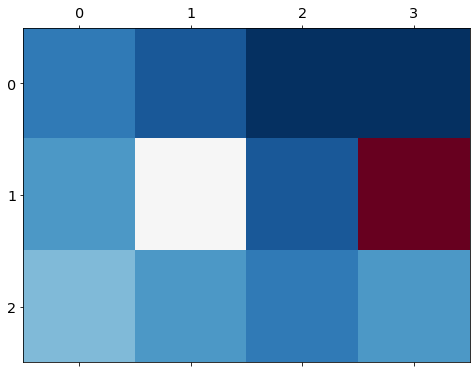

In [16]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)
show_grid(V)